# BİL 401(Big Data) Project Final Report
## Credit Card Fraud Detection
### Ömer Faruk Özgül (191101025) - Talha Çetin (201101036)

In [1]:
import findspark
#windows
#findspark.init('C:\spark')

#mac
import sys
sys.path.append("/opt/homebrew/Cellar/apache-spark/3.5.0/libexec/python")
sys.path.append("/opt/homebrew/Cellar/apache-spark/3.5.0/libexec/python/lib/py4j-0.10.9.7-src.zip")
findspark.init("/opt/homebrew/Cellar/apache-spark/3.5.0/libexec")

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Spark session'un oluşturulması
spark = SparkSession.builder.master('local[*]').appName('test').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/17 23:50:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/17 23:50:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/12/17 23:50:41 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/12/17 23:50:41 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [4]:
# datasetin okunması
df = spark.read.csv('credit_card_transactions.csv', header = True, inferSchema = True)

In [5]:
df.printSchema()

root
 |-- User: integer (nullable = true)
 |-- Card: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Amount: string (nullable = true)
 |-- Use Chip: string (nullable = true)
 |-- Merchant Name: long (nullable = true)
 |-- Merchant City: string (nullable = true)
 |-- Merchant State: string (nullable = true)
 |-- Zip: double (nullable = true)
 |-- MCC: integer (nullable = true)
 |-- Errors?: string (nullable = true)
 |-- Is Fraud?: string (nullable = true)



In [6]:
df.limit(10).show()

+----+----+----+-----+---+-------------------+-------+-----------------+--------------------+-------------+--------------+-------+----+-------+---------+
|User|Card|Year|Month|Day|               Time| Amount|         Use Chip|       Merchant Name|Merchant City|Merchant State|    Zip| MCC|Errors?|Is Fraud?|
+----+----+----+-----+---+-------------------+-------+-----------------+--------------------+-------------+--------------+-------+----+-------+---------+
|   0|   0|2002|    9|  1|2023-12-17 06:21:00|$134.09|Swipe Transaction| 3527213246127876953|     La Verne|            CA|91750.0|5300|   NULL|       No|
|   0|   0|2002|    9|  1|2023-12-17 06:42:00| $38.48|Swipe Transaction| -727612092139916043|Monterey Park|            CA|91754.0|5411|   NULL|       No|
|   0|   0|2002|    9|  2|2023-12-17 06:22:00|$120.34|Swipe Transaction| -727612092139916043|Monterey Park|            CA|91754.0|5411|   NULL|       No|
|   0|   0|2002|    9|  2|2023-12-17 17:45:00|$128.95|Swipe Transaction| 341

In [7]:
df.describe().toPandas()

23/12/17 23:50:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,count,24386900,24386900,24386900,24386900,24386900,24386900,24386900,24386900,24386900,21666079,21508765,24386900,388431,24386900
1,mean,1001.0193350938414,1.351366184303868,2011.9551699067943,6.52506357921671,15.718122721625134,None,None,-4.7692296277308365E17,None,None,50956.44211506332,5561.171253336833,None,None
2,stddev,569.461157032364,1.4071536259341337,5.105920688923689,3.4723548345729336,8.794073288462647,None,None,4.7589398706839798E18,None,None,29397.065949063544,879.3154327182826,None,None
3,min,0,0,1991,1,1,$-0.00,Chip Transaction,-9222899435637403521,Aaronsburg,AA,501.0,1711,Bad CVV,No
4,max,1999,8,2020,12,31,$999.97,Swipe Transaction,9223291803303717674,Zwolle,Zimbabwe,99928.0,9402,Technical Glitch,Yes


In [8]:
# null değerlerin kolonlara göre sayısı
null_counts = df.select([count(when((col(column).isNull()), column)).alias(column) for column in df.columns])
null_counts.show()

+----+----+----+-----+---+----+------+--------+-------------+-------------+--------------+-------+---+--------+---------+
|User|Card|Year|Month|Day|Time|Amount|Use Chip|Merchant Name|Merchant City|Merchant State|    Zip|MCC| Errors?|Is Fraud?|
+----+----+----+-----+---+----+------+--------+-------------+-------------+--------------+-------+---+--------+---------+
|   0|   0|   0|    0|  0|   0|     0|       0|            0|            0|       2720821|2878135|  0|23998469|        0|
+----+----+----+-----+---+----+------+--------+-------------+-------------+--------------+-------+---+--------+---------+



# Preprocessing / Cleaning

In [9]:
# Time kolonunun saat ve dakika verilerini aldıktan sonra yıl, ay, gün ve saat bilgilerini tek kolonda birleştiriyoruz
df = df.withColumn("Time", split(df["Time"], " ").getItem(1))
df = df.withColumn('Timestamp',to_timestamp(concat(col('Year').cast('string'), lit('-'), col('Month').cast('string'), lit('-'), col('Day').cast('string'), lit(' '),
                col('Time')), "yyyy-M-d HH:mm:ss"))
df = df.drop("Year","Month","Day","Time")

In [10]:
df.select("Timestamp").show()

+-------------------+
|          Timestamp|
+-------------------+
|2002-09-01 06:21:00|
|2002-09-01 06:42:00|
|2002-09-02 06:22:00|
|2002-09-02 17:45:00|
|2002-09-03 06:23:00|
|2002-09-03 13:53:00|
|2002-09-04 05:51:00|
|2002-09-04 06:09:00|
|2002-09-05 06:14:00|
|2002-09-05 09:35:00|
|2002-09-05 20:18:00|
|2002-09-05 20:41:00|
|2002-09-06 06:16:00|
|2002-09-07 06:16:00|
|2002-09-07 06:34:00|
|2002-09-07 09:39:00|
|2002-09-08 06:10:00|
|2002-09-08 06:38:00|
|2002-09-08 13:48:00|
|2002-09-08 22:01:00|
+-------------------+
only showing top 20 rows



In [11]:
# Amount sütunundaki para birimi simgelerini kaldırıp sayısal bir formata dönüştürelim
df = df.withColumn("Amount", regexp_replace(col("Amount"), "[\$,]", "").cast("double"))

In [12]:
df.limit(5).show()
df.schema['Amount'].dataType

+----+----+------+-----------------+-------------------+-------------+--------------+-------+----+-------+---------+-------------------+
|User|Card|Amount|         Use Chip|      Merchant Name|Merchant City|Merchant State|    Zip| MCC|Errors?|Is Fraud?|          Timestamp|
+----+----+------+-----------------+-------------------+-------------+--------------+-------+----+-------+---------+-------------------+
|   0|   0|134.09|Swipe Transaction|3527213246127876953|     La Verne|            CA|91750.0|5300|   NULL|       No|2002-09-01 06:21:00|
|   0|   0| 38.48|Swipe Transaction|-727612092139916043|Monterey Park|            CA|91754.0|5411|   NULL|       No|2002-09-01 06:42:00|
|   0|   0|120.34|Swipe Transaction|-727612092139916043|Monterey Park|            CA|91754.0|5411|   NULL|       No|2002-09-02 06:22:00|
|   0|   0|128.95|Swipe Transaction|3414527459579106770|Monterey Park|            CA|91754.0|5651|   NULL|       No|2002-09-02 17:45:00|
|   0|   0|104.71|Swipe Transaction|58172

DoubleType()

In [13]:
# kolonları yeniden düzenleyelim
new_col_order = df.columns
timestamp = new_col_order.pop(new_col_order.index("Timestamp"))
new_col_order.insert(new_col_order.index("Amount"), timestamp)
df = df.select(*new_col_order)

df.limit(10).show()

+----+----+-------------------+------+-----------------+--------------------+-------------+--------------+-------+----+-------+---------+
|User|Card|          Timestamp|Amount|         Use Chip|       Merchant Name|Merchant City|Merchant State|    Zip| MCC|Errors?|Is Fraud?|
+----+----+-------------------+------+-----------------+--------------------+-------------+--------------+-------+----+-------+---------+
|   0|   0|2002-09-01 06:21:00|134.09|Swipe Transaction| 3527213246127876953|     La Verne|            CA|91750.0|5300|   NULL|       No|
|   0|   0|2002-09-01 06:42:00| 38.48|Swipe Transaction| -727612092139916043|Monterey Park|            CA|91754.0|5411|   NULL|       No|
|   0|   0|2002-09-02 06:22:00|120.34|Swipe Transaction| -727612092139916043|Monterey Park|            CA|91754.0|5411|   NULL|       No|
|   0|   0|2002-09-02 17:45:00|128.95|Swipe Transaction| 3414527459579106770|Monterey Park|            CA|91754.0|5651|   NULL|       No|
|   0|   0|2002-09-03 06:23:00|104

In [14]:
# "Is Fraud?" kolonunun değerlerini düzenleyelim
df = df.withColumn('Is Fraud?', when(df['Is Fraud?'] == 'Yes', 1).otherwise(0))

In [15]:
df.select('Is Fraud?').distinct().show()

+---------+
|Is Fraud?|
+---------+
|        1|
|        0|
+---------+



In [16]:
# 'Errors' sütunundaki eksik değerleri "No Error" ile dolduralım
df = df.withColumn("Errors?", when(col("Errors?").isNull(), "No Error").otherwise(col("Errors?")))

In [17]:
df.filter(col("Errors?").isNull()).count()

0

In [18]:
# 'Merchant State' için en sık görülen değeri bulup eksik değerleri dolduruyoruz
# Bu, eksik verilerin rastgele dağıldığı ve dolandırıcılıkla ilişkili olmadığı tespitine dayanıyor.
# En sık görülen değer, veri setimizin gerçek dağılımını temsil eden bir değer olduğu için tercih edilmiştir.
most_common_state = df.groupBy("Merchant State").count().orderBy(col("count").desc()).head(2)[-1][0]
df = df.withColumn("Merchant State", when(col("Merchant State").isNull(), most_common_state).otherwise(col("Merchant State")))

In [19]:
df.filter(col("Merchant State").isNull()).count()

0

In [20]:
# 'Zip' kodu için de benzer bir işlem yaparak eksik değerleri en sık görülen posta kodu ile dolduruyoruz.
# Bu yaklaşım, modelimizin eğitiminde tutarlılık sağlamak ve eksik veri kaynaklı önyargıları önlemek için kullanılır.
most_common_zip = df.groupBy("Zip").count().orderBy(col("count").desc()).head(2)[-1][0]
df = df.withColumn("Zip", when(col("Zip").isNull(), most_common_zip).otherwise(col("Zip")))

In [21]:
df.filter(col("Zip").isNull()).count()

0

# Exploratory Data Analysis

### Map-Reduce ile Toplam Dolandırıcılık Miktarının Hesaplanması

In [22]:
# Fraud olan transactionlar RDD'ye dönüştürüyoruz
fraud_transactions = df.filter(df['Is Fraud?'] == 1).rdd

# 'map' işlemi ile işlem tutarını çıkarıyoruz
fraud_amounts = fraud_transactions.map(lambda row: row.Amount)

# 'reduce' işlemi ile toplam tutarı hesaplıyoruz
total_fraud_amount = fraud_amounts.reduce(lambda x, y: x + y)

# Toplam miktarı dolar olarak formatlama
formatted_total_fraud_amount = "${:,.2f}".format(total_fraud_amount)
print("Toplam Dolandırıcılık Miktarı: ", formatted_total_fraud_amount)


Toplam Dolandırıcılık Miktarı:  $3,231,338.63


### Map-Reduce ile Dolandırıcılık İşlemlerinin Eyaletlere Göre Dağılımı

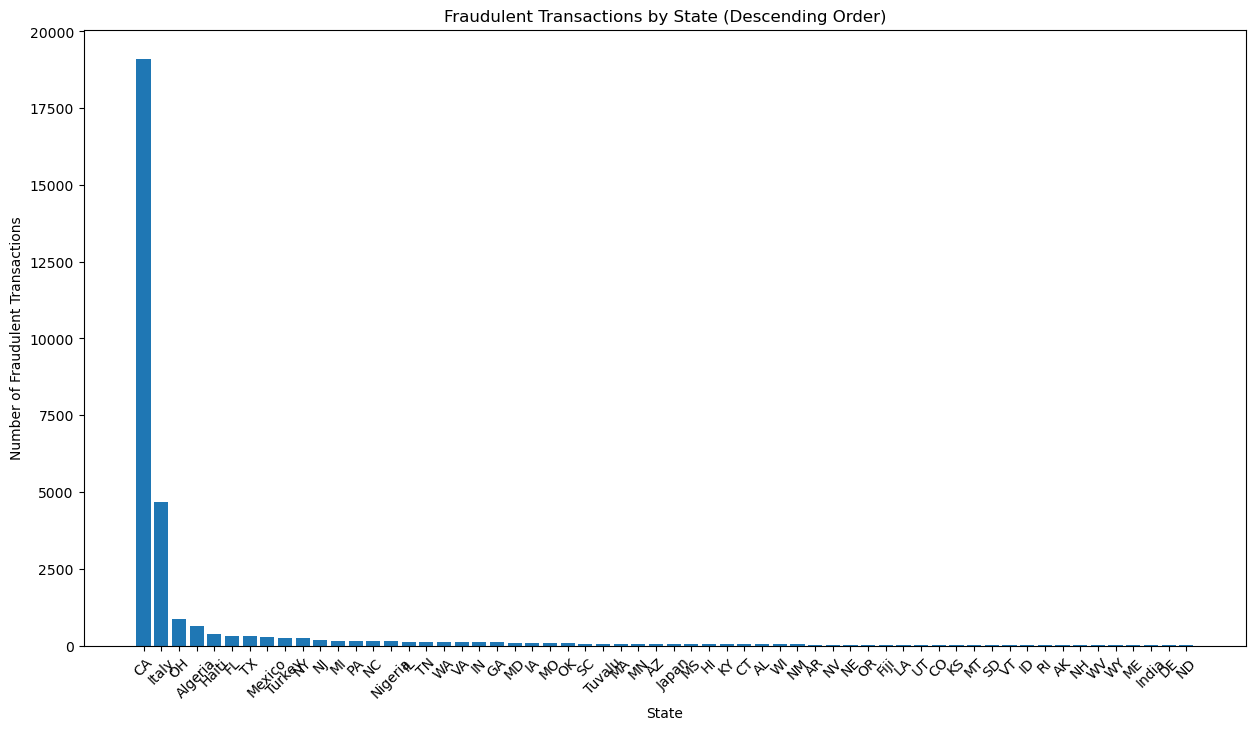

In [23]:
# Eyalet ve dolandırıcılık durumunu çıkarma
state_frauds = fraud_transactions.map(lambda row: (row['Merchant State'], 1))

# Eyaletlere göre toplamı hesaplama ve azalan sırada sıralama
state_fraud_counts = state_frauds.reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending=False)

# Verileri toplama
states, counts = zip(*state_fraud_counts.collect())

# Bar grafiği çizme
plt.figure(figsize=(15, 8))  # Grafiğin boyutunu ayarlama
plt.bar(states, counts)
plt.title('Fraudulent Transactions by State (Descending Order)')
plt.xlabel('State')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)  # Eyalet isimlerini okunaklı hale getirmek için
plt.show()

### Fraud (Sahte) ve Not Fraud (Sahte Olmayan) Değerlerin Dağılımı

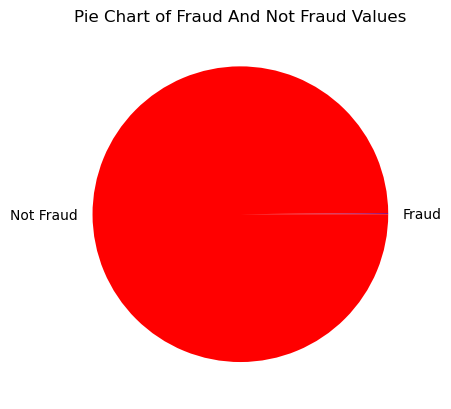

Frauds: 0.12202042900081601 % of the dataset
No Frauds: 99.87797957099919 % of the dataset


In [24]:
plt.pie([df[df["Is Fraud?"] == 1].count(), df[df["Is Fraud?"] == 0].count()], labels=["Fraud","Not Fraud"],colors=["purple","red"])
plt.title("Pie Chart of Fraud And Not Fraud Values")
plt.show()

fraud_percentage = df.select(avg(df["Is Fraud?"]).alias("FraudPercentage")).first()["FraudPercentage"] * 100
no_fraud_percentage = 100 - fraud_percentage
print('Frauds:', fraud_percentage, '% of the dataset')
print('No Frauds:', no_fraud_percentage, '% of the dataset')

### Günlük İşlem Grafiği

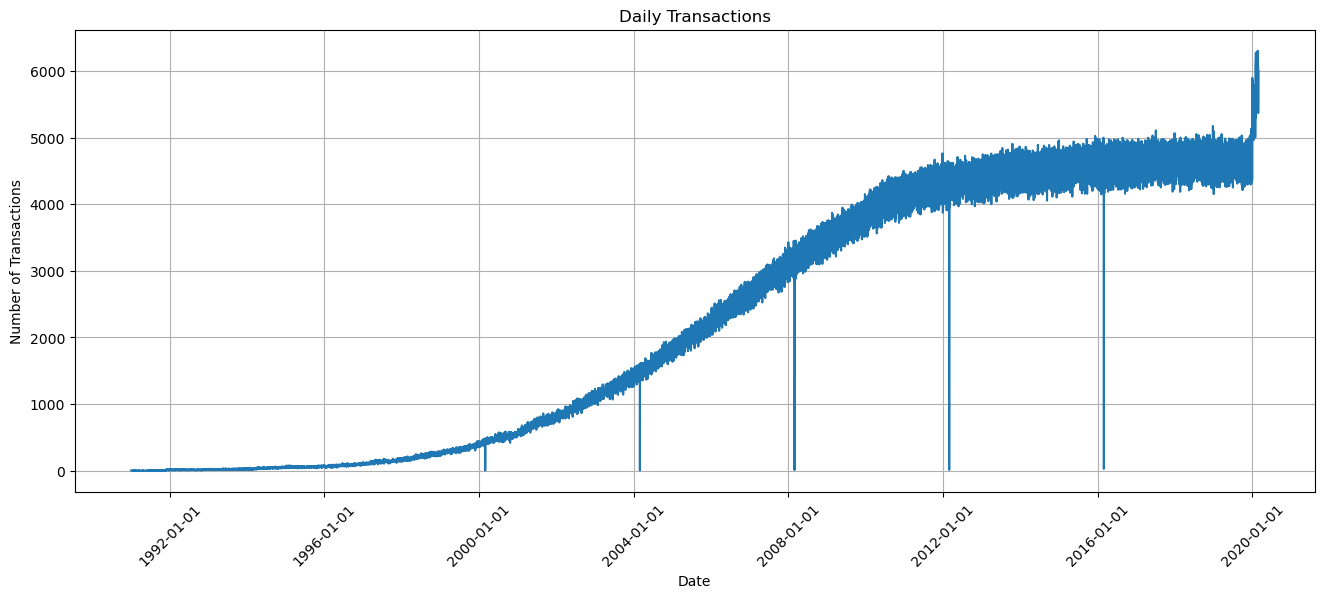

In [25]:
from matplotlib.dates import DateFormatter

daily_transactions = df.groupBy(to_date(df['Timestamp']).alias('Date')).agg(count('User').alias('TransactionCount')).orderBy('Date')
pandas_df = daily_transactions.toPandas()

date_format = DateFormatter('%Y-%m-%d')
plt.figure(figsize=(16, 6))
plt.plot(pandas_df['Date'], pandas_df['TransactionCount'], linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Daily Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()

### Saatlik Dolandırıcılık İşlem Grafiği

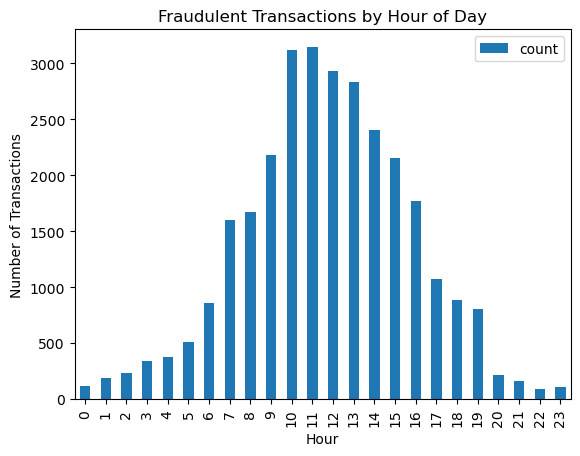

In [26]:
fraud_df = df.filter(df['Is Fraud?'] == 1)
fraud_df = fraud_df.withColumn('Hour', hour('Timestamp'))
fraud_df.groupBy('Hour').count().orderBy('Hour').toPandas().plot(kind='bar', x='Hour', y='count')
plt.title('Fraudulent Transactions by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.show()

### Hata Türlerine Göre Dolandırıcılık İşlem Analizi

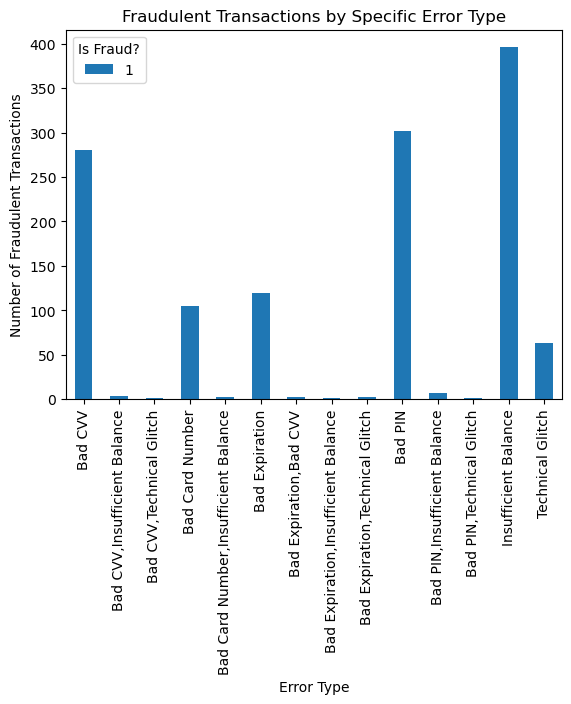

In [27]:
# "No Error" olmayan ve "Is Fraud?" değeri 1 olan verileri filtreleyerek yeni bir DataFrame oluşturuyoruz
error_fraud_df = df.filter((df['Errors?'] != 'No Error') & (df['Is Fraud?'] == 1))
error_fraud_counts = error_fraud_df.groupBy('Errors?', 'Is Fraud?').count().toPandas()
error_fraud_counts.pivot(index='Errors?', columns='Is Fraud?', values='count').plot(kind='bar', stacked=True)
plt.title('Fraudulent Transactions by Specific Error Type')
plt.xlabel('Error Type')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

### Sahte İşlem Tutarlarının Dağılımı

In [28]:
fraud_data = df[df['Is Fraud?'] == 1].toPandas()

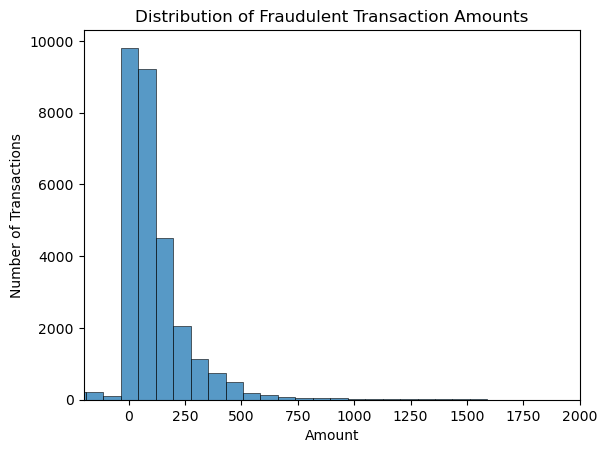

In [29]:
sns.histplot(fraud_data['Amount'].astype(float), kde=False, bins=80)
plt.title('Distribution of Fraudulent Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim(-200, 2000)
plt.show()

### Sahte İşlemlerin Coğrafi Dağılımı

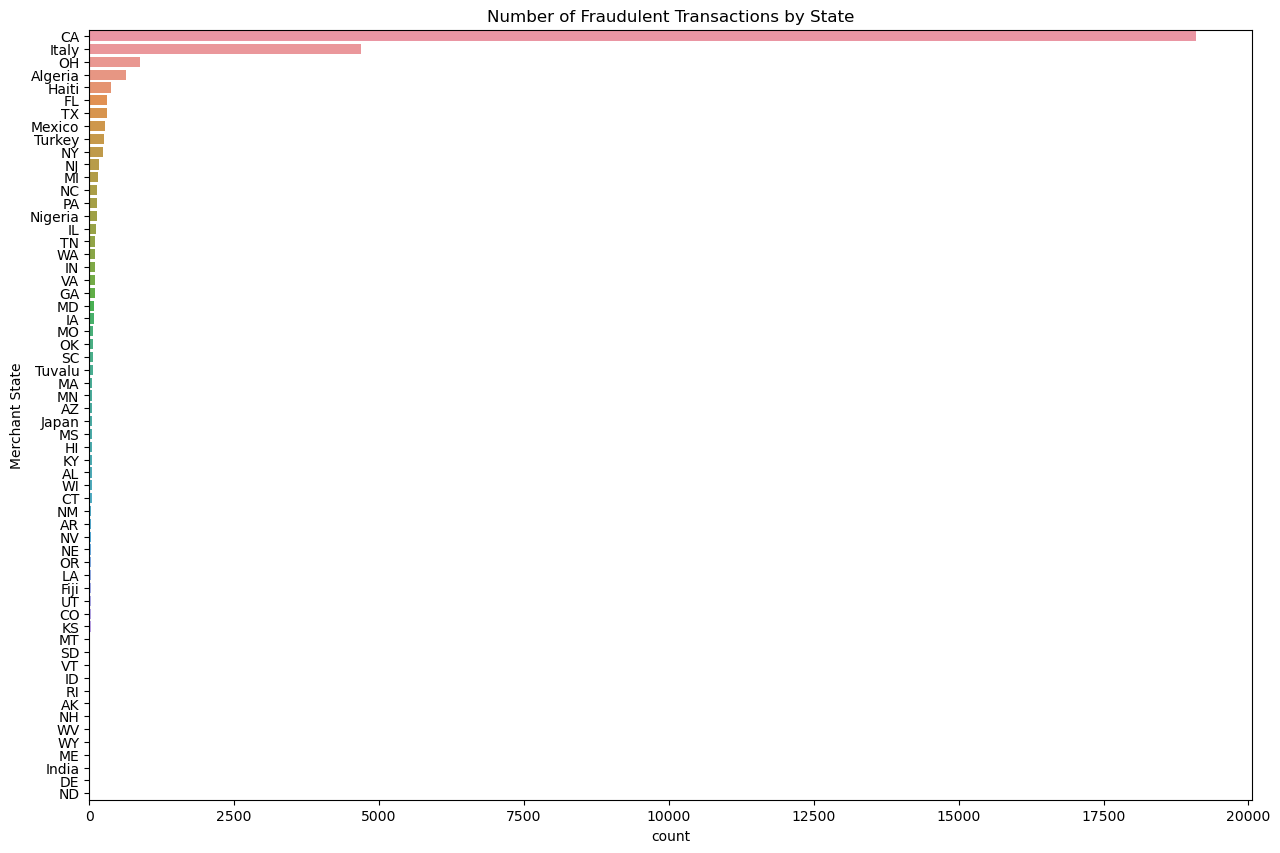

In [30]:
plt.figure(figsize=(15, 10))  
sns.countplot(data=fraud_data, y='Merchant State', order=fraud_data['Merchant State'].value_counts().index)
plt.title('Number of Fraudulent Transactions by State')
plt.show()

### Sahte İşlemlerin İşlem Türüne Göre Dağılımı

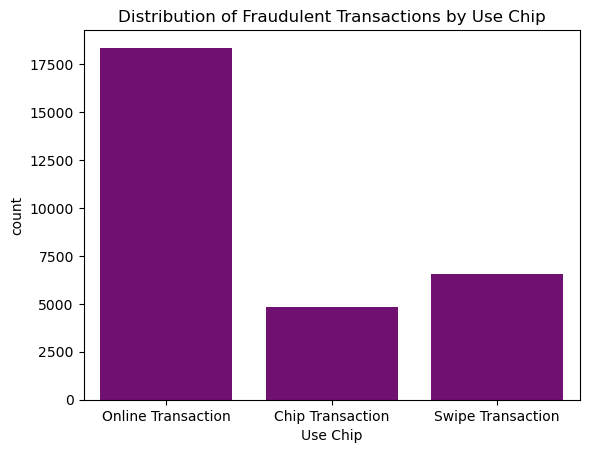

In [31]:
sns.countplot(data=fraud_data, x='Use Chip', color="purple")
plt.title('Distribution of Fraudulent Transactions by Use Chip')
plt.show()

### İlk 10 Eyalet için Dolandırıcılık Durumuna Göre Dağılımı

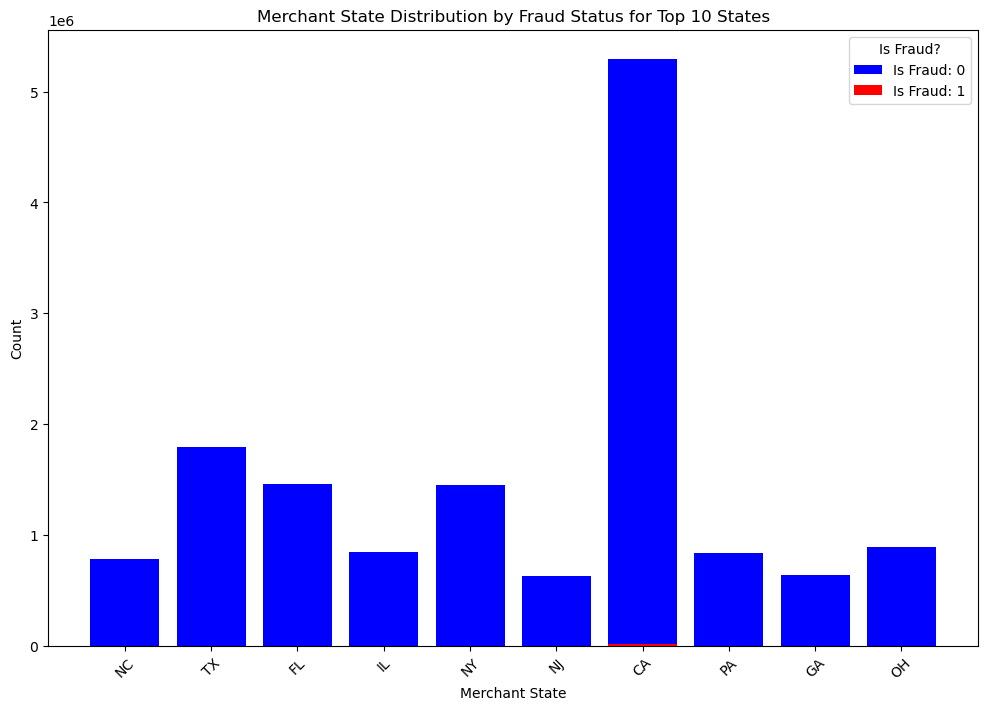

In [32]:
top_states = df.groupBy("Merchant State").count().orderBy(col("count").desc()).limit(10)
top_states_df = df.join(top_states, "Merchant State", "inner")

plt.figure(figsize=(12, 8))
top_states_counts = top_states_df.groupBy("Merchant State", "Is Fraud?").count().toPandas()

colors = {1: 'r', 0: 'b'}
for is_fraud, data in top_states_counts.groupby("Is Fraud?"):
    plt.bar(data["Merchant State"], data["count"], color=colors[is_fraud], label=f'Is Fraud: {is_fraud}')
plt.title('Merchant State Distribution by Fraud Status for Top 10 States')
plt.xlabel('Merchant State')
plt.ylabel('Count')
plt.legend(title='Is Fraud?')
plt.xticks(rotation=45)
plt.show()

### Korelasyon Matrisi

In [33]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

assembler = VectorAssembler(inputCols=["User", "Card","Amount","Merchant Name","Zip","MCC","Is Fraud?"], outputCol="features")
df_assembled = assembler.transform(df).select("features")

correlation_matrix = Correlation.corr(df_assembled, "features").collect()[0][0]
corrmatrix = correlation_matrix.toArray().tolist()

23/12/17 23:54:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/17 23:54:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


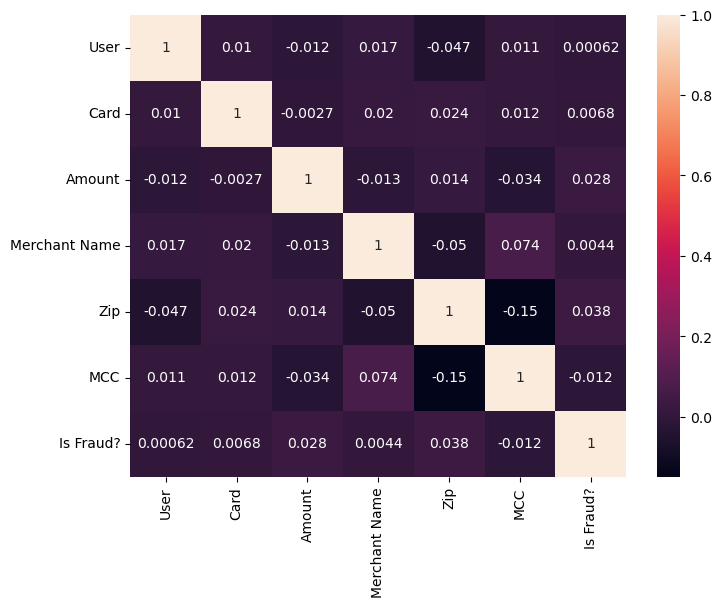

In [34]:
plt.figure(figsize=(8,6))
sns.heatmap(corrmatrix, xticklabels=["User", "Card","Amount","Merchant Name","Zip","MCC","Is Fraud?"], yticklabels=["User", "Card","Amount","Merchant Name","Zip","MCC","Is Fraud?"], annot=True)
plt.show()

# Fraud Detection with MLLib

## 1 - Data Preprocessing

Based on the EDA above, we will concentrate on variables that appear to exert a more significant impact on the likelihood of a case being fraudulent. Eliminating the variables with high percentage of missing value, we've chosen the following variables for modelling:

Year, Day of Week, Hour, Amount, Use Chip, Merchant Name, Merchant City, MCC.

In [35]:
df.limit(5).show()

+----+----+-------------------+------+-----------------+-------------------+-------------+--------------+-------+----+--------+---------+
|User|Card|          Timestamp|Amount|         Use Chip|      Merchant Name|Merchant City|Merchant State|    Zip| MCC| Errors?|Is Fraud?|
+----+----+-------------------+------+-----------------+-------------------+-------------+--------------+-------+----+--------+---------+
|   0|   0|2002-09-01 06:21:00|134.09|Swipe Transaction|3527213246127876953|     La Verne|            CA|91750.0|5300|No Error|        0|
|   0|   0|2002-09-01 06:42:00| 38.48|Swipe Transaction|-727612092139916043|Monterey Park|            CA|91754.0|5411|No Error|        0|
|   0|   0|2002-09-02 06:22:00|120.34|Swipe Transaction|-727612092139916043|Monterey Park|            CA|91754.0|5411|No Error|        0|
|   0|   0|2002-09-02 17:45:00|128.95|Swipe Transaction|3414527459579106770|Monterey Park|            CA|91754.0|5651|No Error|        0|
|   0|   0|2002-09-03 06:23:00|104

In [36]:
# Veri Setinin Ön İşlenmesi
df = df.withColumn("Year", split(split(col("timestamp"), " ")[0], "-")[0])  # Yıl
df = df.withColumn("Day of Week", split(split(col("timestamp"), " ")[0], "-")[2])  # Gün
df = df.withColumn("Hour", split(split(col("timestamp"), " ")[1], ":")[0])  # Saat

# Seçilen Sütunlar
selected_cols = ['Year', 'Day of Week', 'Hour', 'Amount', 'Use Chip', 'Merchant Name', 'MCC', 'Is Fraud?']
df = df.select(selected_cols)
df = df.withColumn('Hour', df['Hour'].cast('float'))

In [37]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# ML İçin Özellik Mühendisliği
assembler = VectorAssembler(inputCols=['Amount'], outputCol="Amount_Vector")
df = assembler.transform(df)

scaler = StandardScaler(inputCol='Amount_Vector', outputCol='ScaledAmount', withStd=True, withMean=False)
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)

In [38]:
# Kategorik Değişkenlerin İşlenmesi
categorical_cols = ['Use Chip', 'Day of Week']
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in categorical_cols]
encoder = OneHotEncoder(inputCols=[col+"_index" for col in categorical_cols], outputCols=[col+"_encoded" for col in categorical_cols])

In [39]:
# Özelliklerin Birleştirilmesi
assemblerInputs = ["ScaledAmount"] + [col+"_encoded" for col in categorical_cols]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [40]:
# RandomForest Sınıflandırıcı Modeli
rf = RandomForestClassifier(labelCol="Is Fraud?", featuresCol="features", seed=42)
pipeline = Pipeline(stages=indexers + [encoder, assembler, rf])

In [41]:
#(train_data, test_data) = df.randomSplit([0.7, 0.3], seed=1613)


In [42]:
# Veri Setinin Bölünmesi
X = df[df['Is Fraud?'] == 0]
Y = df[df['Is Fraud?'] == 1]

print(X.count())
print(Y.count())

24357143


29757


In [43]:
# Örneklem Alma
X_sampled = X.sample(False, 0.01, seed=42)

# 0 ve 1 olan verileri birleştirme
df_sampled = X_sampled.union(Y)

In [46]:
# Eğitim ve Test Verilerinin Hazırlanması
train_df, test_df = df_sampled.randomSplit([0.6, 0.4], seed=42)

# Modelin Eğitilmesi ve Tahminlerin Yapılması
model = pipeline.fit(train_df)
predictions = model.transform(test_df)

In [47]:
# Model Değerlendirmesi
evaluator = MulticlassClassificationEvaluator(labelCol="Is Fraud?", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print("F1 Score:", f1_score)

F1 Score: 0.8383505899202509
